# HCP Vector Pipeline

## Importing Native Files

In [18]:
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [19]:
import datetime
import dill
import matplotlib.pyplot as plt
import numpy as np
from optimization import SGD, GD
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score
import torch

## Prepare HCP Data

In [20]:
#Load fMRI Resting State Data
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Print Shape of Data for Sanity
print(fmri_rs.shape)

#Take the Transpose so that each Sample is a Row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

(79800, 753)


In [21]:
#Create Train and Test Arrays corresponding to Training and Test Subjects
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape Labels into Column Vectors
X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Preprocessing Step

In [22]:
#Row Wise Normalization of Samples
def normalize_rows(matrix: np.ndarray):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    return normalized_matrix

#Preprocess Data
X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)

## Global Hyperparameters

In [23]:
use_bias = False
lamb = 0.19

## Closed Form Solver

In [24]:
from sklearn.linear_model import Ridge

#Create Ridge Model with specific alpha value and fit to (X_train, Y_train)
model = Ridge(alpha = lamb, solver = 'svd', fit_intercept = use_bias)
model.fit(X_train, Y_train)

#Get Y_train predicted using model weights
Y_train_pred = model.predict(X_train).reshape((-1, 1))
weights = model.coef_.reshape((-1, 1))
W_true = weights

#Calculate Optimal Value
p_star = (np.linalg.norm(Y_train - Y_train_pred) ** 2) + (lamb * (np.linalg.norm(weights) ** 2))
print(f"Value of p^*: {p_star}")

#Compute Training Error Metrics
train_nmse_loss = np.sum(np.square((Y_train_pred - Y_train))) / np.sum(np.square(Y_train))
train_correlation = np.corrcoef(Y_train_pred.flatten(), Y_train.flatten())[0, 1]
train_R2_score = r2_score(Y_train, Y_train_pred)
error_metrics = [train_nmse_loss, train_correlation, train_R2_score]

print('-----------------------------Training Error Metrics---------------------------------')
print(f"NMSE: {train_nmse_loss}")
print(f"Correlation: {train_correlation}")
print(f"R2_Score: {train_R2_score}")

Y_test_predicted =  model.predict(X_test).reshape((-1, 1))

#Compute Test Error Metrics
test_nmse_loss = np.sum(np.square((Y_test_predicted - Y_test))) / np.sum(np.square(Y_test))
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]
test_R2_score = r2_score(Y_test, Y_test_predicted)
error_metrics = [test_nmse_loss,test_correlation,test_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NMSE: {test_nmse_loss}")
print(f"Correlation: {test_correlation}")
print(f"R2_Score: {test_R2_score}")

Value of p^*: 893.8554852163037
-----------------------------Training Error Metrics---------------------------------
NMSE: 0.13485415894185068
Correlation: 0.9409419085028259
R2_Score: 0.8188839647676105
-----------------------------Testing Error Metrics---------------------------------
NMSE: 0.729350721526266
Correlation: 0.5008633955204339
R2_Score: 0.21808866080977785


## Gradient Descent[Exact Line Search] Solver

In [25]:
max_epochs = 1000
optimizer_code = 0

hypers = {'lambda': lamb, 'epochs': max_epochs, 'bias': use_bias}
W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values = GD(X = X_train, Y = Y_train, cost_function_code = 1, hypers = hypers, p_star = p_star, W_true = W_true)

Epoch [1/1000], Learning Rate: 0.0011, Loss: 2472.6572, Gap to Optimality: 1578.8017, Iterate Norm: 1.5020859241485596, NEE: 0.9963476296744918, NMSE: 0.7342501282691956, Correlation: 0.26437992936564886, R2: 0.013864596802108942
Gradient Norm for linear.weight: 1292.1943359375
Epoch [2/1000], Learning Rate: 0.0713, Loss: 2124.1145, Gap to Optimality: 1230.2590, Iterate Norm: 7.20862340927124, NEE: 0.823304806329302, NMSE: 0.6279281377792358, Correlation: 0.5019225502312429, R2: 0.15666041072595283
Gradient Norm for linear.weight: 98.88053894042969
Epoch [3/1000], Learning Rate: 0.0011, Loss: 1984.2018, Gap to Optimality: 1090.3463, Iterate Norm: 7.334286212921143, NEE: 0.8211122952008221, NMSE: 0.5862709879875183, Correlation: 0.5068272921136661, R2: 0.21260810872017766
Gradient Norm for linear.weight: 505.8687438964844
Epoch [4/1000], Learning Rate: 0.0310, Loss: 1895.2000, Gap to Optimality: 1001.3445, Iterate Norm: 8.714759826660156, NEE: 0.7650748560591222, NMSE: 0.558587253093719

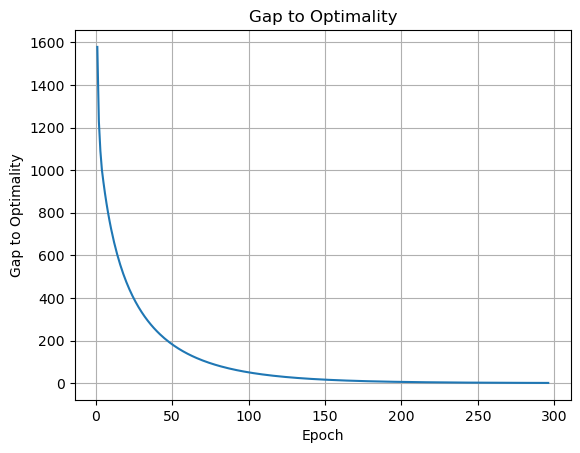

In [26]:
plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
plt.title('Gap to Optimality')
plt.xlabel('Epoch')
plt.ylabel('Gap to Optimality')
plt.grid(True)
plt.show()

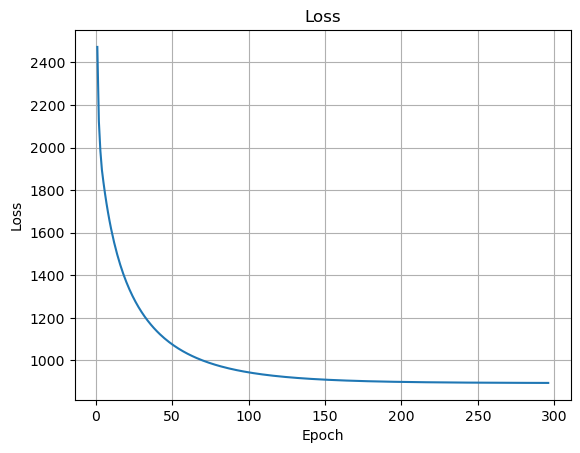

In [27]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Stochastic Gradient Descent Solver

In [43]:
lr = 1e-3
epochs = 100
batch_size = 16
use_bias = False
optimizer_code = 0

W_init = None

hypers = {'lambda': lamb, 'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'bias': use_bias, 'optimizer_code': optimizer_code}
cost_function_code = 1

W_estimated, b_estimated, losses, gap_to_optimality, fixed_point_stochastic_gradients, fixed_point_stochastic_gradient_norms, fixed_point_full_gradients, fixed_point_full_gradient_norms, iterates, iterate_norms, full_gradients, \
    full_gradient_norms, stochastic_gradients, stochastic_gradient_norms, nee_values, nmse_values, corr_values, R2_values, epochs_ran = SGD(X = X_train, Y = Y_train, cost_function_code = cost_function_code, hypers = hypers, optimizer_code = optimizer_code, p_star = p_star, W_true = W_true, W_init = W_init)

Epoch [1/100], Loss: 2612.3193, Gap to Optimality: 1718.4639, Fixed Point Stochastic Gradient Norm: 10.2256, Fixed Point Full Gradient Norm: 1287.4607, Iterate Norm: 1.0100, Full Gradient Norm: 1287.4607,  Stochastic Gradient Norm: 3.1496, NEE: 0.9967565038971401, NMSE: 0.7757993340492249, Correlation: 0.2898546699299685, R2: -0.04193813419944026
Epoch [2/100], Loss: 2490.0227, Gap to Optimality: 1596.1672, Fixed Point Stochastic Gradient Norm: 10.1866, Fixed Point Full Gradient Norm: 518.4508, Iterate Norm: 1.2840, Full Gradient Norm: 518.4508,  Stochastic Gradient Norm: 6.5164, NEE: 0.993983195555982, NMSE: 0.7394420504570007, Correlation: 0.3221287833980787, R2: 0.0068916321330555474
Epoch [3/100], Loss: 2460.4697, Gap to Optimality: 1566.6142, Fixed Point Stochastic Gradient Norm: 8.6421, Fixed Point Full Gradient Norm: 239.8171, Iterate Norm: 1.4119, Full Gradient Norm: 239.8171,  Stochastic Gradient Norm: 4.9594, NEE: 0.9913567081009798, NMSE: 0.7306452989578247, Correlation: 0.3

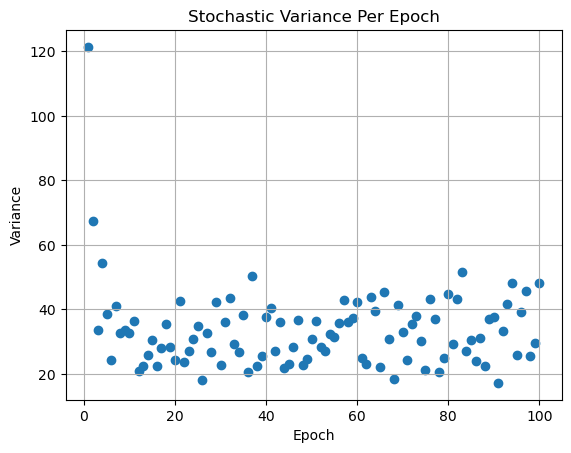

In [44]:
### Analysis of Fixed Point Gradients
fixed_point_stochastic_gradient_norms = fixed_point_stochastic_gradient_norms.reshape(epochs_ran, -1)
fixed_point_full_gradient_norms = fixed_point_full_gradient_norms.reshape(epochs_ran, -1)

stochastic_variance_per_epoch = np.var(fixed_point_stochastic_gradient_norms - fixed_point_full_gradient_norms, axis = 1)

plt.scatter(range(1, len(stochastic_variance_per_epoch)+1), stochastic_variance_per_epoch)
plt.title('Stochastic Variance Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

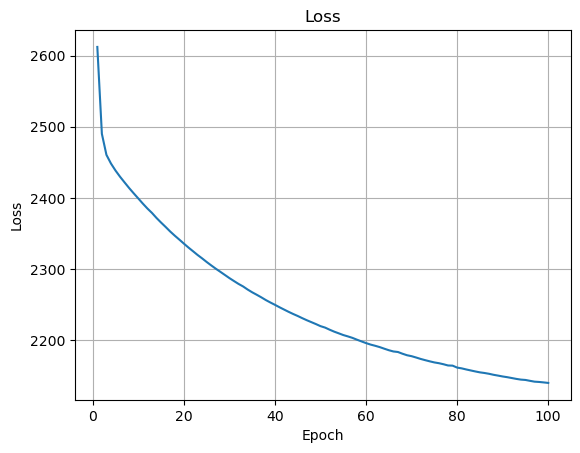

In [45]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

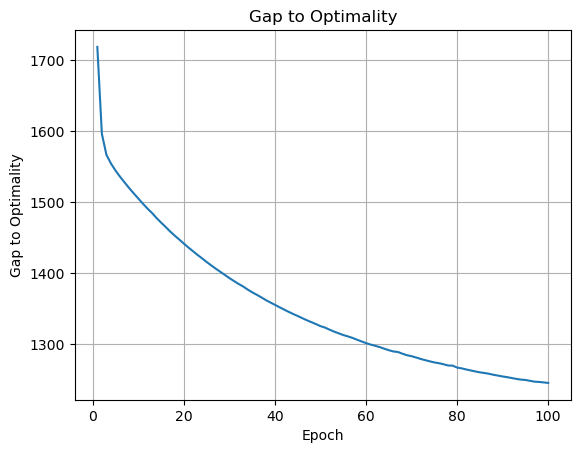

In [46]:
plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
plt.title('Gap to Optimality')
plt.xlabel('Epoch')
plt.ylabel('Gap to Optimality')
plt.grid(True)
plt.show()

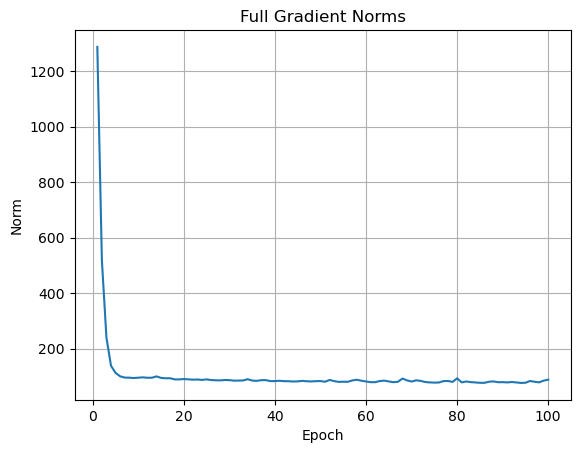

In [47]:
plt.plot(range(1, len(full_gradient_norms)+1), full_gradient_norms)
plt.title('Full Gradient Norms')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

In [48]:
full_gradient_norms

array([1287.4607  ,  518.4508  ,  239.81714 ,  138.39511 ,  112.41117 ,
        100.14641 ,   95.59148 ,   95.2391  ,   93.94625 ,   95.191635,
         96.39846 ,   94.86426 ,   95.069595,   99.77858 ,   94.31583 ,
         93.085556,   93.21681 ,   89.00518 ,   88.86475 ,   90.346375,
         89.17503 ,   87.98539 ,   88.65953 ,   87.07624 ,   89.091675,
         86.63774 ,   85.810455,   85.481865,   86.780174,   86.406624,
         84.47063 ,   84.77449 ,   85.15566 ,   89.6772  ,   84.82526 ,
         83.68013 ,   86.21549 ,   86.354195,   82.82013 ,   82.87701 ,
         84.03711 ,   82.70968 ,   82.37629 ,   81.41636 ,   81.898094,
         83.744995,   82.24104 ,   81.67643 ,   82.69135 ,   83.01882 ,
         80.441696,   87.10527 ,   82.75593 ,   79.998924,   80.680626,
         80.38409 ,   85.31293 ,   87.80283 ,   84.16641 ,   81.53789 ,
         79.013824,   78.962326,   83.02973 ,   84.61002 ,   81.64428 ,
         78.93943 ,   80.411934,   92.03969 ,   85.420135,   81.

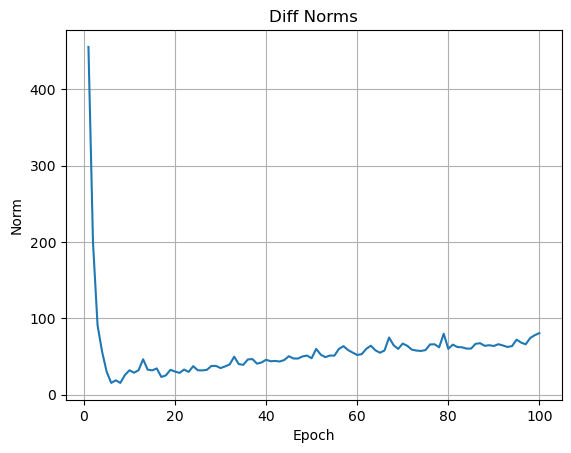

In [49]:
stochastic_group_size = int(len(stochastic_gradients) / epochs_ran)

A = []
A_norms = []

#Iterate through Full Gradients
for idx in range(len(full_gradients)):
    full_gradient = full_gradients[idx] #Get Full Gradient
    
    #Get Stochastic Gradients
    start = idx * stochastic_group_size
    end = (idx + 1) * stochastic_group_size
    stochastic_slice = stochastic_gradients[start:end]
    
    #Compute Sum of Stochastic Gradients
    tensor_sum = 0
    for idx2 in range(len(stochastic_slice)):
        tensor_sum += stochastic_slice[idx2]
    
    diff = tensor_sum - full_gradient
    A.append(diff)
    A_norms.append(torch.norm(diff).item())
    
plt.plot(range(1, len(A_norms)+1), A_norms)
plt.title('Diff Norms')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()